In [2]:
# %load eigenfaces.py
"""
===================================================
Faces recognition example using eigenfaces and SVMs
===================================================

The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  .. _LFW: http://vis-www.cs.umass.edu/lfw/

  original source: http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html

"""



print __doc__

from time import time
import logging
import pylab as pl
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import RandomizedPCA
from sklearn.svm import SVC


Faces recognition example using eigenfaces and SVMs

The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  .. _LFW: http://vis-www.cs.umass.edu/lfw/

  original source: http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html




C:\Users\JehyeonHeo\Anaconda3\envs\py27\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\JehyeonHeo\Anaconda3\envs\py27\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
###############################################################################
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)

# for machine learning we use the data directly (as relative pixel
# position info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print "Total dataset size:"
print "n_samples: %d" % n_samples
print "n_features: %d" % n_features
print "n_classes: %d" % n_classes

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [4]:
###############################################################################
# Split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

In [5]:
###############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
t0 = time()
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
print "done in %0.3fs" % (time() - t0)

eigenfaces = pca.components_.reshape((n_components, h, w))

print "Projecting the input data on the eigenfaces orthonormal basis"
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print "done in %0.3fs" % (time() - t0)

Extracting the top 150 eigenfaces from 966 faces
done in 0.135s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.011s


C:\Users\JehyeonHeo\Anaconda3\envs\py27\lib\site-packages\sklearn\utils\deprecation.py:57: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


In [13]:
#How much of the variance is explained by the first principal component? The second?
print "The variance of the first principal component:", pca.explained_variance_ratio_[0]
print "The variance of the second principal component:", pca.explained_variance_ratio_[1]

 The variance of the first principal component: 0.193465
The variance of the second principal component: 0.151168


In [6]:
###############################################################################
# Train a SVM classification model

print "Fitting the classifier to the training set"
t0 = time()
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print "done in %0.3fs" % (time() - t0)
print "Best estimator found by grid search:"
print clf.best_estimator_

Fitting the classifier to the training set
done in 13.294s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [7]:
###############################################################################
# Quantitative evaluation of the model quality on the test set

print "Predicting the people names on the testing set"
t0 = time()
y_pred = clf.predict(X_test_pca)
print "done in %0.3fs" % (time() - t0)

print classification_report(y_test, y_pred, target_names=target_names)
print confusion_matrix(y_test, y_pred, labels=range(n_classes))

Predicting the people names on the testing set
done in 0.044s
                   precision    recall  f1-score   support

     Ariel Sharon       0.70      0.54      0.61        13
     Colin Powell       0.83      0.87      0.85        60
  Donald Rumsfeld       0.94      0.63      0.76        27
    George W Bush       0.83      0.98      0.90       146
Gerhard Schroeder       0.95      0.76      0.84        25
      Hugo Chavez       1.00      0.47      0.64        15
       Tony Blair       0.94      0.81      0.87        36

      avg / total       0.86      0.85      0.84       322

[[  7   1   0   5   0   0   0]
 [  1  52   0   7   0   0   0]
 [  1   2  17   6   0   0   1]
 [  0   3   0 143   0   0   0]
 [  0   1   0   4  19   0   1]
 [  0   3   0   4   1   7   0]
 [  1   1   1   4   0   0  29]]


In [8]:
###############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())

In [9]:
# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

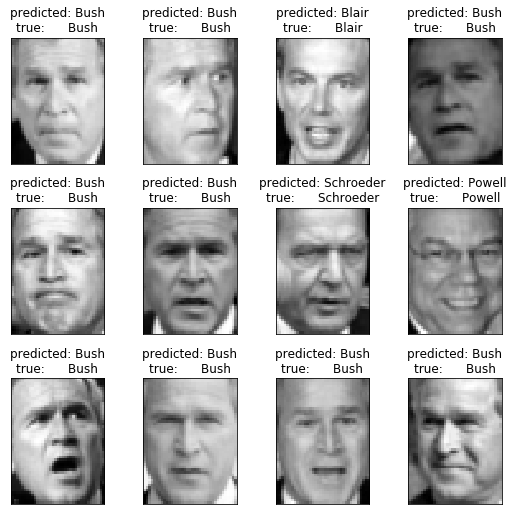

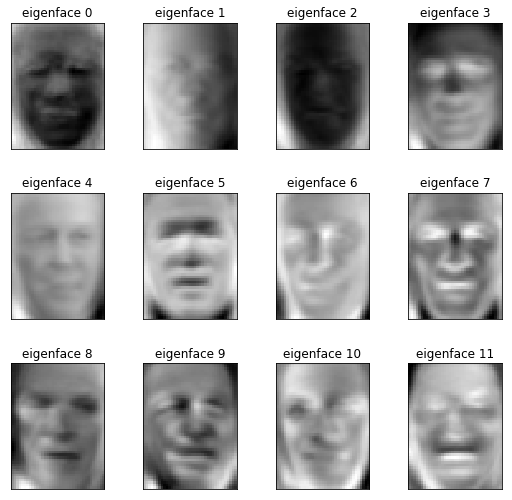

In [10]:
# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

pl.show()

In [15]:
#Change n_components to the following values: [10, 15, 25, 50, 100, 250]. 
#For each number of principal components, note the F1 score for Ariel Sharon.
n_components = [10, 15, 25, 50, 100, 250]

def use_different_n_for_pca(n_components):
    print "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
    t0 = time()
    pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
    print "done in %0.3fs" % (time() - t0)

    eigenfaces = pca.components_.reshape((n_components, h, w))

    print "Projecting the input data on the eigenfaces orthonormal basis"
    t0 = time()
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    print "done in %0.3fs" % (time() - t0)

    ###############################################################################
    # Train a SVM classification model

    print "Fitting the classifier to the training set"
    t0 = time()
    param_grid = {
             'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
              }
    # for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
    clf = clf.fit(X_train_pca, y_train)
    print "done in %0.3fs" % (time() - t0)
    print "Best estimator found by grid search:"
    print clf.best_estimator_

    ###############################################################################
    # Quantitative evaluation of the model quality on the test set

    print "Predicting the people names on the testing set"
    t0 = time()
    y_pred = clf.predict(X_test_pca)
    print "done in %0.3fs" % (time() - t0)

    print classification_report(y_test, y_pred, target_names=target_names)
    print "\n\n"
    
for n in n_components:
    use_different_n_for_pca(n)

Extracting the top 10 eigenfaces from 966 faces
done in 0.022s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.008s
Fitting the classifier to the training set


C:\Users\JehyeonHeo\Anaconda3\envs\py27\lib\site-packages\sklearn\utils\deprecation.py:57: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 36.990s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.009s
                   precision    recall  f1-score   support

     Ariel Sharon       0.11      0.15      0.12        13
     Colin Powell       0.44      0.52      0.47        60
  Donald Rumsfeld       0.23      0.33      0.27        27
    George W Bush       0.66      0.60      0.63       146
Gerhard Schroeder       0.15      0.16      0.15        25
      Hugo Chavez       0.33      0.13      0.19        15
       Tony Blair       0.46      0.33      0.39        36

      avg / total       0.48      0.46      0.47       322




Extracting the top 15 eigenfaces from 966 faces
done in 0.017s
Projecting the input data on the eigenfaces orthonorma

C:\Users\JehyeonHeo\Anaconda3\envs\py27\lib\site-packages\sklearn\utils\deprecation.py:57: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 10.982s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.009s
                   precision    recall  f1-score   support

     Ariel Sharon       0.46      0.46      0.46        13
     Colin Powell       0.67      0.68      0.68        60
  Donald Rumsfeld       0.47      0.56      0.51        27
    George W Bush       0.74      0.77      0.75       146
Gerhard Schroeder       0.61      0.44      0.51        25
      Hugo Chavez       0.54      0.47      0.50        15
       Tony Blair       0.59      0.56      0.57        36

      avg / total       0.66      0.66      0.66       322




Extracting the top 25 eigenfaces from 966 faces
done in 0.018s
Projecting the input data on the eigenfaces orthonorma

C:\Users\JehyeonHeo\Anaconda3\envs\py27\lib\site-packages\sklearn\utils\deprecation.py:57: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 5.468s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.009s
                   precision    recall  f1-score   support

     Ariel Sharon       0.75      0.69      0.72        13
     Colin Powell       0.70      0.83      0.76        60
  Donald Rumsfeld       0.57      0.63      0.60        27
    George W Bush       0.84      0.79      0.81       146
Gerhard Schroeder       0.54      0.56      0.55        25
      Hugo Chavez       0.79      0.73      0.76        15
       Tony Blair       0.66      0.58      0.62        36

      avg / total       0.74      0.74      0.74       322




Extracting the top 50 eigenfaces from 966 faces
done in 0.021s
Projecting the input data on the eigenfaces orthonorma

C:\Users\JehyeonHeo\Anaconda3\envs\py27\lib\site-packages\sklearn\utils\deprecation.py:57: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 4.695s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.015s
                   precision    recall  f1-score   support

     Ariel Sharon       0.60      0.69      0.64        13
     Colin Powell       0.82      0.88      0.85        60
  Donald Rumsfeld       0.68      0.56      0.61        27
    George W Bush       0.84      0.90      0.87       146
Gerhard Schroeder       0.86      0.72      0.78        25
      Hugo Chavez       0.92      0.73      0.81        15
       Tony Blair       0.84      0.72      0.78        36

      avg / total       0.82      0.82      0.81       322




Extracting the top 100 eigenfaces from 966 faces
done in 0.032s
Projecting the input data on the eigenfaces orthonorm

C:\Users\JehyeonHeo\Anaconda3\envs\py27\lib\site-packages\sklearn\utils\deprecation.py:57: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 8.717s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.028s
                   precision    recall  f1-score   support

     Ariel Sharon       0.69      0.69      0.69        13
     Colin Powell       0.80      0.88      0.84        60
  Donald Rumsfeld       0.84      0.59      0.70        27
    George W Bush       0.89      0.96      0.92       146
Gerhard Schroeder       0.75      0.72      0.73        25
      Hugo Chavez       0.89      0.53      0.67        15
       Tony Blair       0.82      0.75      0.78        36

      avg / total       0.84      0.84      0.84       322




Extracting the top 250 eigenfaces from 966 faces
done in 0.067s
Projecting the input data on the eigenfaces orthonor

C:\Users\JehyeonHeo\Anaconda3\envs\py27\lib\site-packages\sklearn\utils\deprecation.py:57: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 22.709s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.064s
                   precision    recall  f1-score   support

     Ariel Sharon       0.71      0.77      0.74        13
     Colin Powell       0.72      0.88      0.79        60
  Donald Rumsfeld       0.69      0.67      0.68        27
    George W Bush       0.92      0.87      0.89       146
Gerhard Schroeder       0.82      0.72      0.77        25
      Hugo Chavez       0.67      0.53      0.59        15
       Tony Blair       0.78      0.78      0.78        36

      avg / total       0.82      0.81      0.81       322




